# Determining Country Development Levels

## Data Source

The data used in this task was orginally sourced from Help.NGO. This international non-governmental organisation specialises in emergency response, preparedness, and risk mitigation.  

## Dataset Attributes
- country: name of the country
- child_mort: death of children under 5 years of age per 1000 live births
- exports: exports of goods and services per capita. Given as a percentage of the GDP per capita
- health: total health spending per capita. Given as a percentage of GDP per capita
- imports: imports of goods and services per capita. Given as a percentage of the GDP per capita
- income: net income per person
- inflation: the measurement of the annual growth rate of the Total GDP
- life_expec: the average number of years a new born child would live if the current mortality patterns remain the same
- total_fer: the number of children that would be born to each woman if the current age-fertility rates remains the same
- gdpp: the GDP per capita. Calculated as the Total GDP divided by the total population.

## Objective  
To group countries using socio-economic and health factors to determine the development status of the country.

In [2]:
# Import libraries
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

In [3]:
# Random state seed
rseed = 42

## Load and explore data

In [4]:
# Import the dataset
df = pd.read_csv('Country-data.csv')

print(df.head())

               country  child_mort  exports  health  imports  income  \
0          Afghanistan        90.2     10.0    7.58     44.9    1610   
1              Albania        16.6     28.0    6.55     48.6    9930   
2              Algeria        27.3     38.4    4.17     31.4   12900   
3               Angola       119.0     62.3    2.85     42.9    5900   
4  Antigua and Barbuda        10.3     45.5    6.03     58.9   19100   

   inflation  life_expec  total_fer   gdpp  
0       9.44        56.2       5.82    553  
1       4.49        76.3       1.65   4090  
2      16.10        76.5       2.89   4460  
3      22.40        60.1       6.16   3530  
4       1.44        76.8       2.13  12200  


In [5]:
# Check shape, datatypes & counts
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB
None


The dataset has 167 records and 10 columns. Each column has 167 non-null entries therefore there are no missing values, and they are all numerical (integer or float) type values, except the country name.

In [6]:
# Get descriptive statistics for numerical columns
print(df.describe())

       child_mort     exports      health     imports         income  \
count  167.000000  167.000000  167.000000  167.000000     167.000000   
mean    38.270060   41.108976    6.815689   46.890215   17144.688623   
std     40.328931   27.412010    2.746837   24.209589   19278.067698   
min      2.600000    0.109000    1.810000    0.065900     609.000000   
25%      8.250000   23.800000    4.920000   30.200000    3355.000000   
50%     19.300000   35.000000    6.320000   43.300000    9960.000000   
75%     62.100000   51.350000    8.600000   58.750000   22800.000000   
max    208.000000  200.000000   17.900000  174.000000  125000.000000   

        inflation  life_expec   total_fer           gdpp  
count  167.000000  167.000000  167.000000     167.000000  
mean     7.781832   70.555689    2.947964   12964.155689  
std     10.570704    8.893172    1.513848   18328.704809  
min     -4.210000   32.100000    1.150000     231.000000  
25%      1.810000   65.300000    1.795000    1330.000000

Using the summary statistics for the data, I can infer that the average life expectancy across all countries is 70.56 years, while the minimum is just 32.1 years, for example.

## Preprocessing and Feature Selection

First I'll drop any non-numeric features. In this case this is just 'country', which contains the country names and won't help to group the data.

In [7]:
df = df.drop('country', axis = 1)

Next I will create a correlation map of features in order to explore relationships.

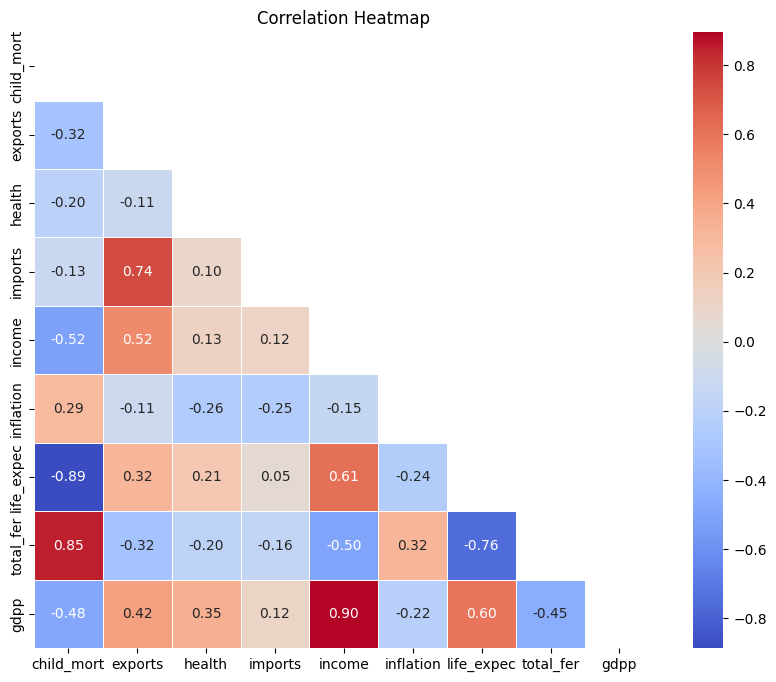

In [8]:
# Create correlation matrix
corr_matrix = df.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype = bool))

# Create the heatmap
plt.figure(figsize = (10, 8))
sns.heatmap(corr_matrix, annot = True, cmap = 'coolwarm', fmt = '.2f', cbar = True, linewidths = 0.5, mask = mask)

# Display the plot
plt.title("Correlation Heatmap")
plt.show()

The strongest positive relationships as shown by the correlation matrix are 'income' with 'gdpp' and 'child_mort' with 'total_fer'. In terms of strong negative correlation it is 'child_mort' with 'life_expec' and 'total_fer' with 'life_expec'.

Now I will explore the continuous independent features against 'child_mort' using scatter plots.

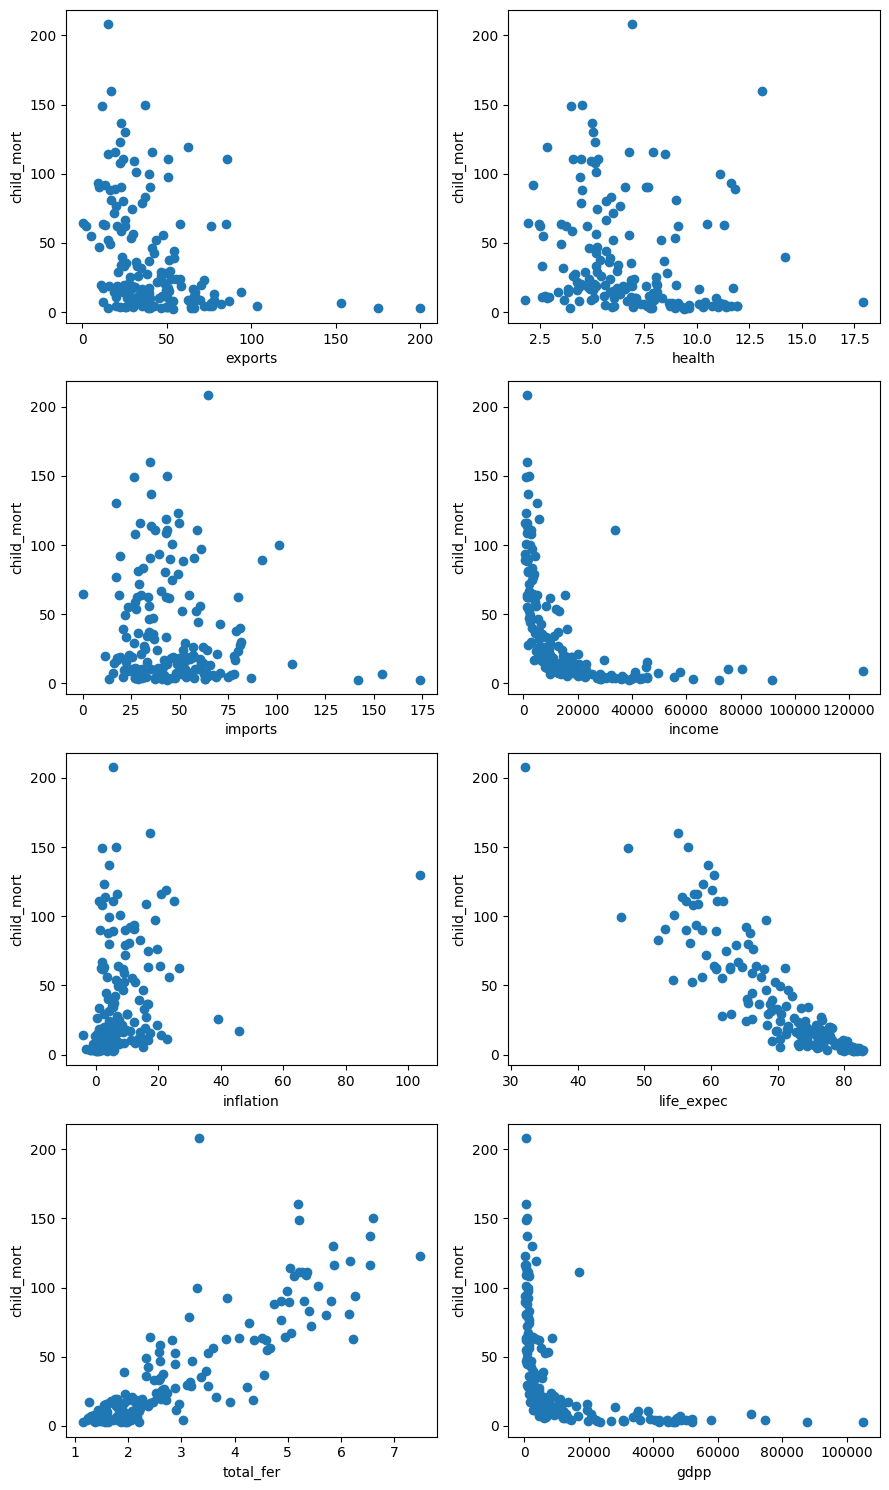

In [9]:
# Create 4x2 grid
fig, axes = plt.subplots(4, 2, figsize = (9, 15))

# Flatten axes array to easily iterate over
axes = axes.flatten()

# Loop through columns excluding child_mort
for i, f in enumerate(df.columns[1:]):
    ax = axes[i] # Get current subplot
    ax.scatter(df[f], df['child_mort'])
    ax.set_xlabel(f)
    ax.set_ylabel('child_mort')

# Adjust layout and show
plt.tight_layout()
plt.show()

There are not very clear relationships between 'child_mort' and 'import', 'exports', 'health', or 'inflation'. 'child_mort' does have pretty strong linear relationships with 'total_fer' and 'life_expec', but the most interesting are the very similar non-linear relationships that are captured when comparing with 'gdpp' and 'income'.

Next I'll compare 'gdpp' against the other continuous variables, in the same way.

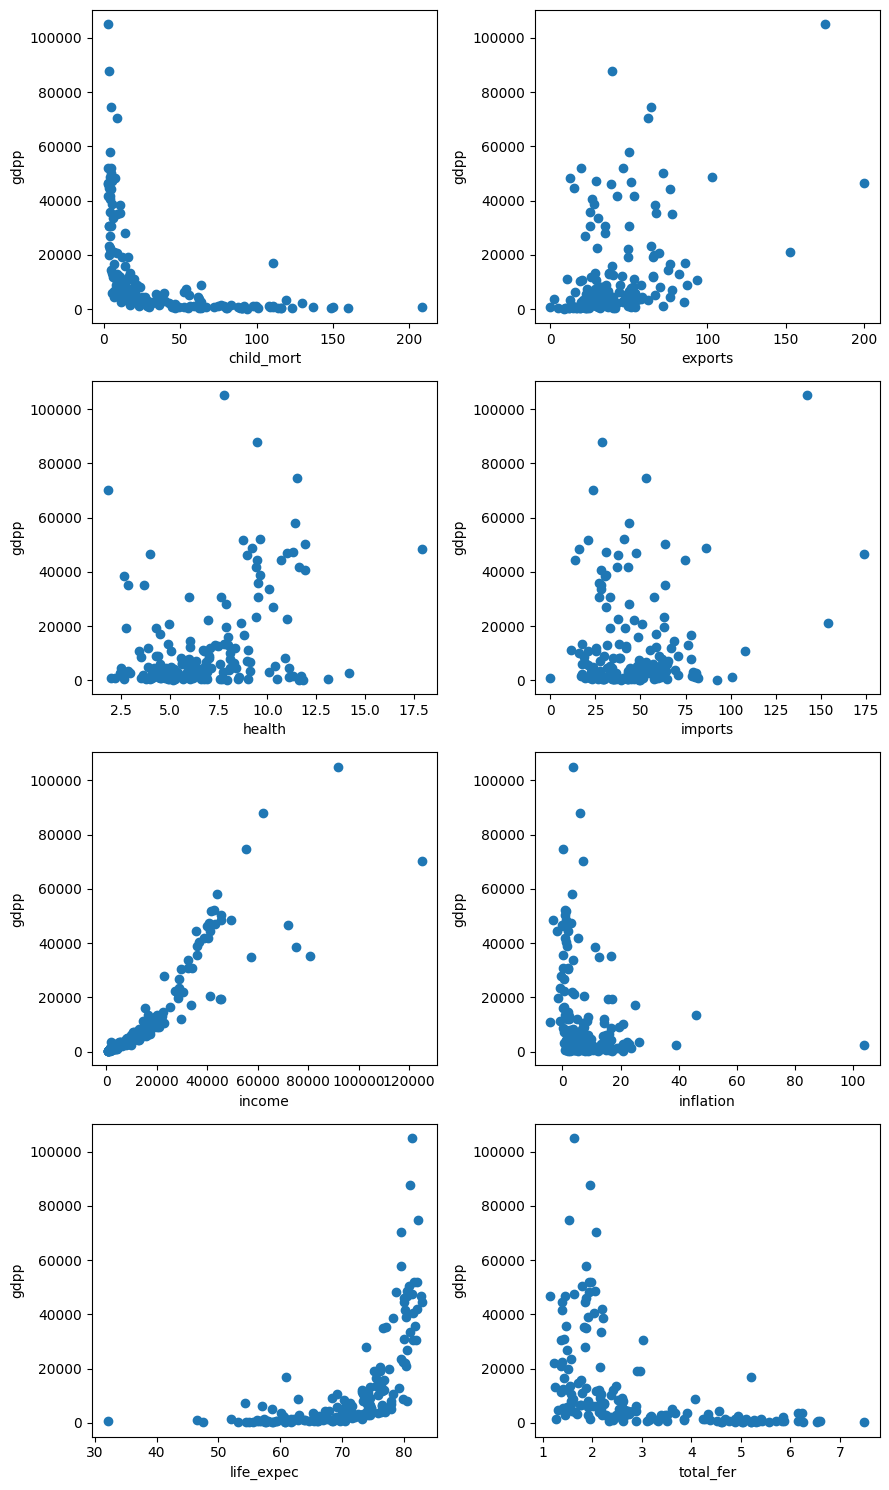

In [10]:
fig, axes = plt.subplots(4, 2, figsize = (9, 15))
axes = axes.flatten()

for i, f in enumerate(df.columns[:-1]):
    ax = axes[i]
    ax.scatter(df[f], df['gdpp'])
    ax.set_xlabel(f)
    ax.set_ylabel('gdpp')

plt.tight_layout()
plt.show()

Below, I create a seaborn pairplot for all variables.

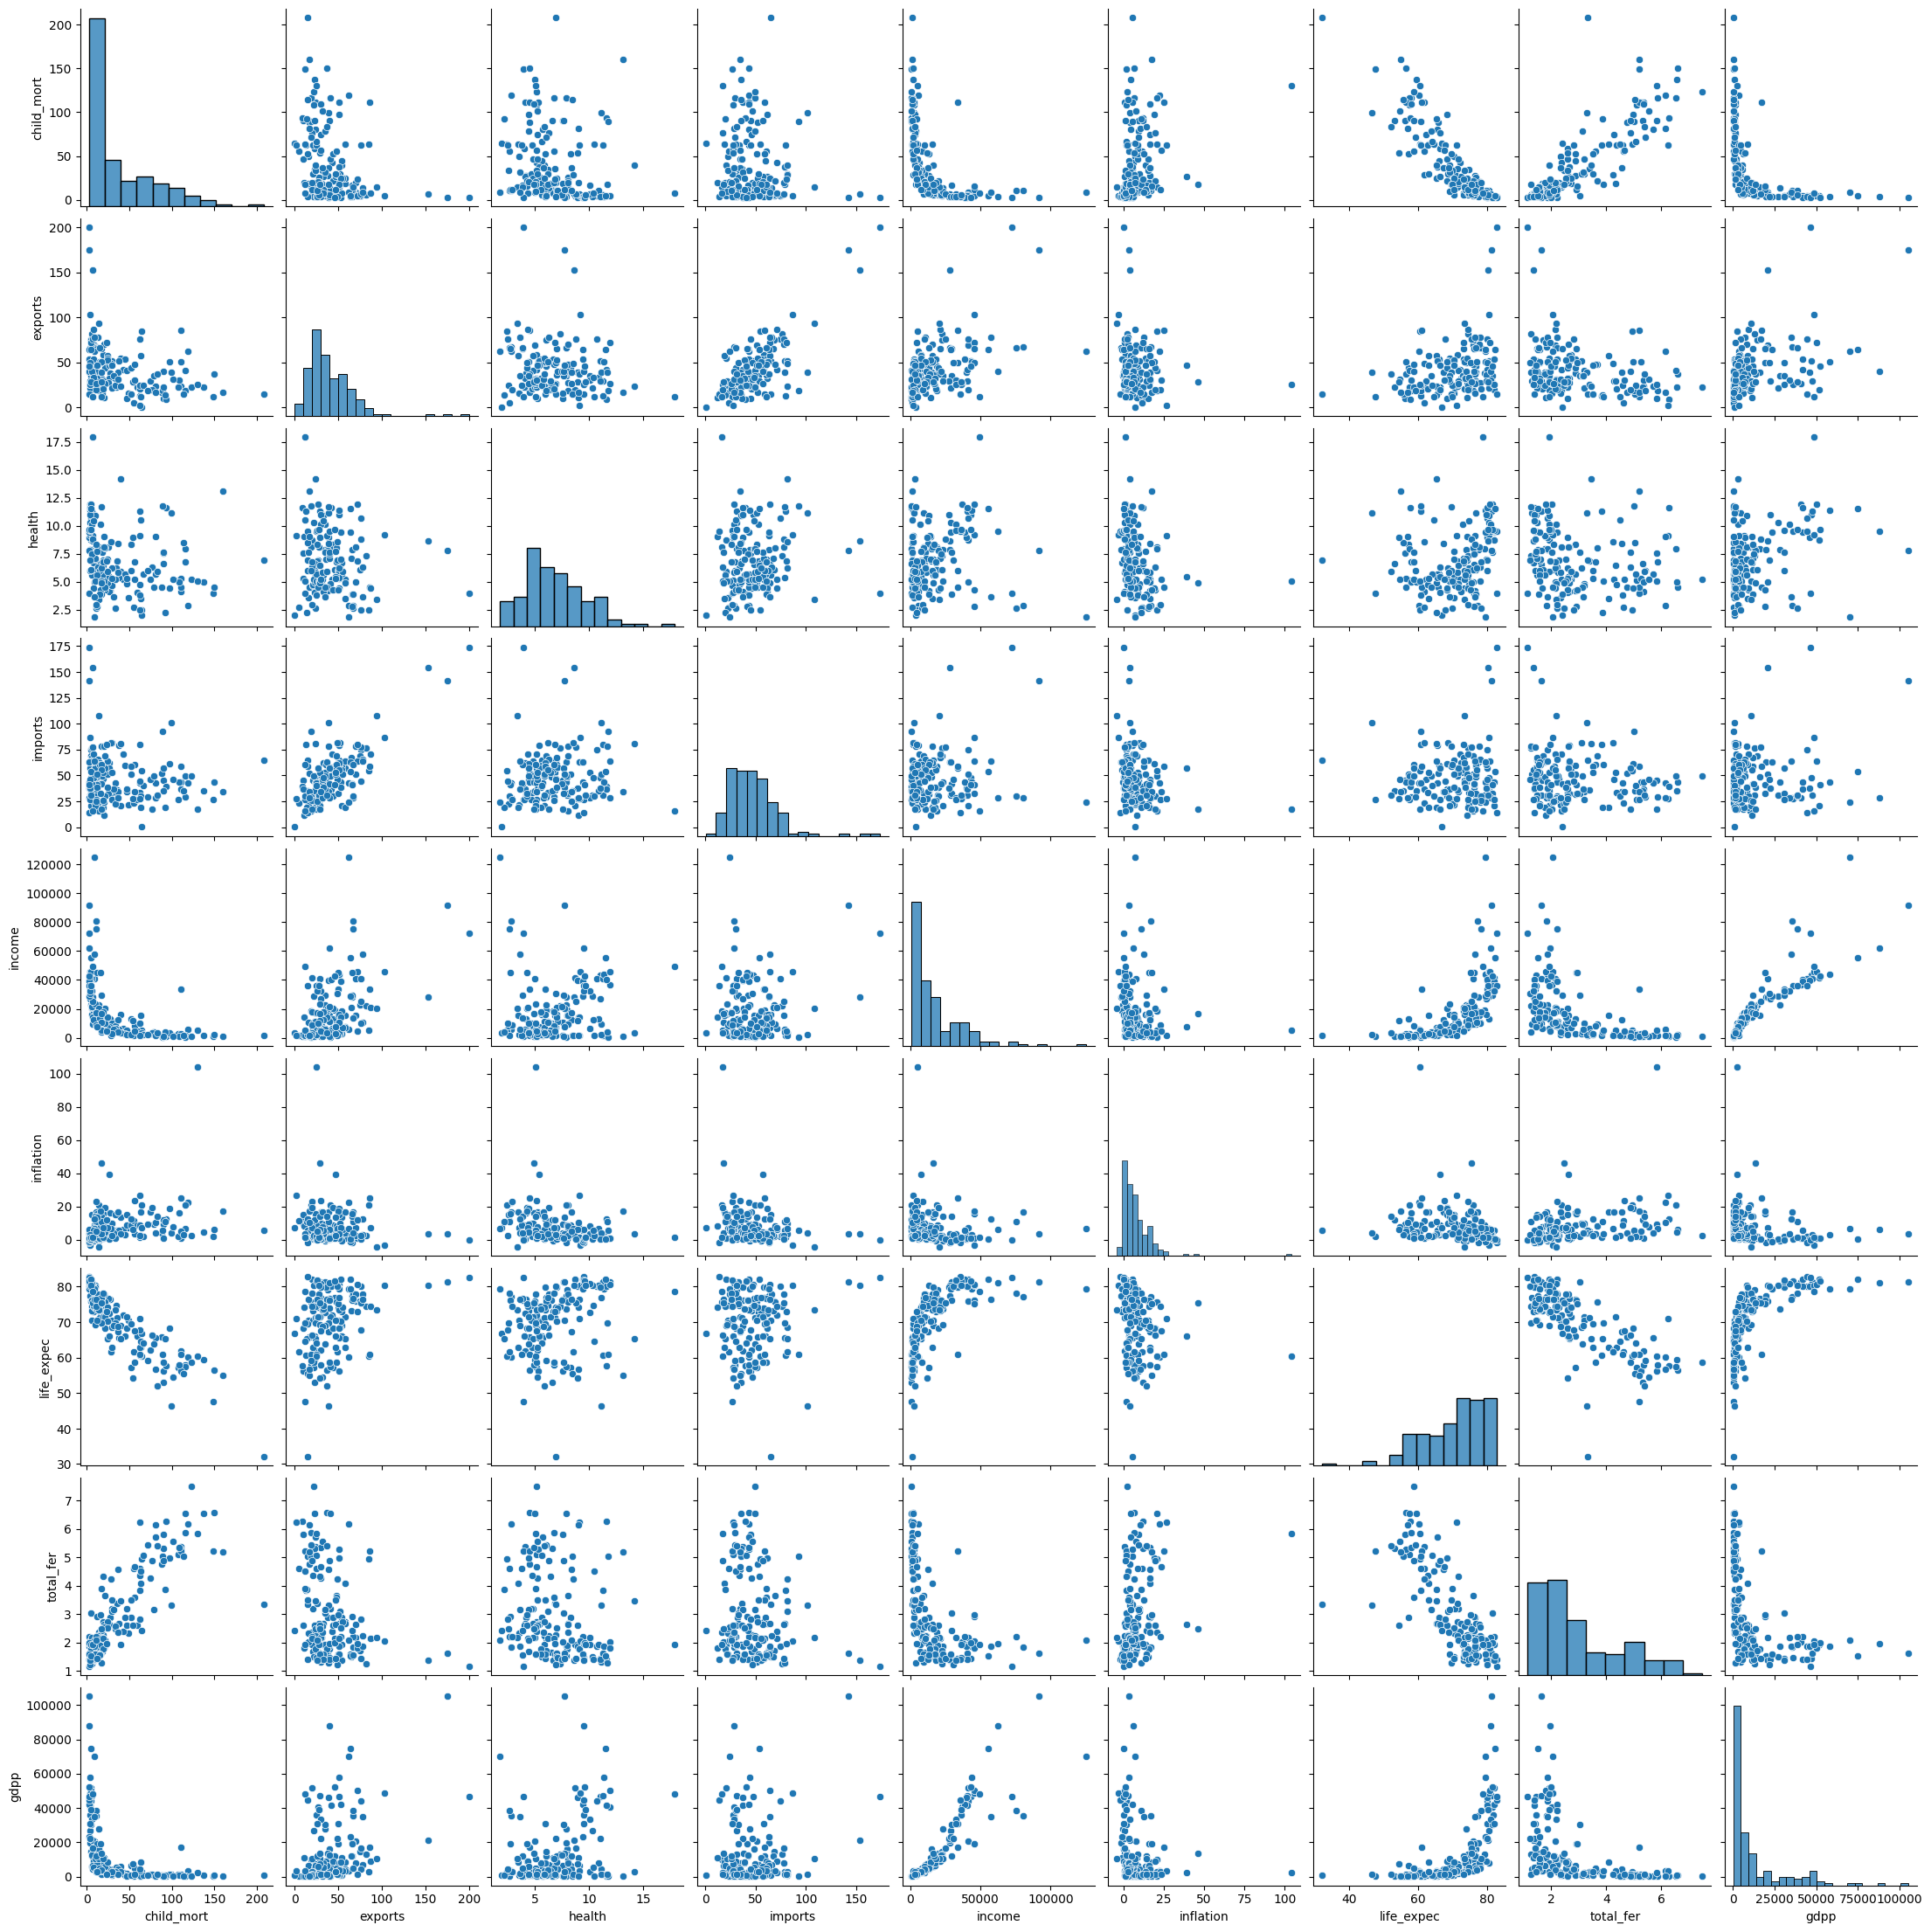

In [11]:
sns.pairplot(df)
plt.show()

Looking at the peaks in the diagonal graphs (histograms) in the pairplot, the features that have the most distinct peaks are 'gdpp', 'income', 'child_mort' and 'inflation'. This suggests these features might be good candidates for clustering the data. Since 'gdpp' and 'income' are very strongly positively correlated, it might not make sense to choose both of these as features as it won't necessarily provide more information than just choosing one.

## Scaling the Data

In this section I will normalise the data using MinMaxScaler, since it is all on very different scales.

In [12]:
# Initialise the MinMaxScaler
scaler = MinMaxScaler()

# Normalise the data
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

df_scaled.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,0.426485,0.049482,0.358608,0.257765,0.008047,0.126144,0.475345,0.736593,0.003073
1,0.068160,0.139531,0.294593,0.279037,0.074933,0.080399,0.871795,0.078864,0.036833
2,0.120253,0.191559,0.146675,0.180149,0.098809,0.187691,0.875740,0.274448,0.040365
3,0.566699,0.311125,0.064636,0.246266,0.042535,0.245911,0.552268,0.790221,0.031488
4,0.037488,0.227079,0.262275,0.338255,0.148652,0.052213,0.881657,0.154574,0.114242


## K-Means Clustering

### Selecting K

In order to find the optimal number of clusters, or K, I will utilise both the elbow and silhouette score methods. Below, I first carry out the elbow method.

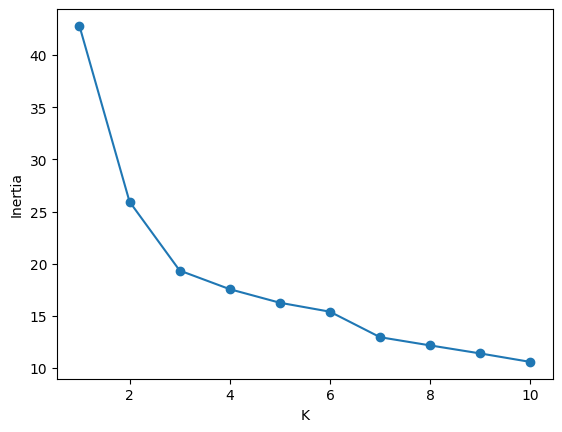

In [13]:
# Plot elbow curve
def eval_Kmeans(x, k, r):
    kmeans = KMeans(n_clusters = k, random_state = r, max_iter = 500)
    kmeans.fit(x)
    return kmeans.inertia_

def elbow_Kmeans(x, max_k = 10, r = rseed):
    within_cluster_vars = [eval_Kmeans(x, k, r) for k in range(1, max_k+1)]
    plt.plot(range(1, 11), within_cluster_vars,marker = 'o')
    plt.xlabel('K')
    plt.ylabel('Inertia')
    plt.show()

elbow_Kmeans(df_scaled)

The elbow looks to be between K=2 or K=3, but let's verify which is most optimal with the silhouette score method.

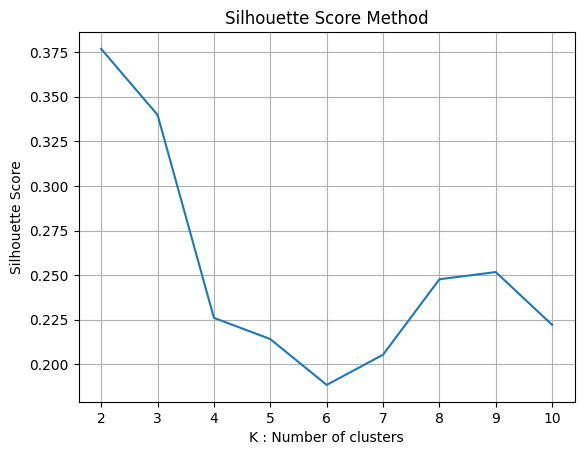

In [14]:
# Silhouette score method
kmax = 10
sil = []
plt.plot()
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters = k, random_state = rseed, max_iter = 500)
    kmeans.fit(df_scaled)
    labels = kmeans.labels_
    sil.append(silhouette_score(df_scaled, labels, metric = 'euclidean'))

sns.lineplot(x = range(2, kmax+1), y = sil)
plt.title('Silhouette Score Method')
plt.xlabel('K : Number of clusters')
plt.ylabel("Silhouette Score")
plt.grid(visible = True)
plt.show()

K=2 is the peak and gives the silhouette score that is closest to 1, so I will choose this value for K. The highest score indicates that for this value of K, the clustering is well-defined and samples are well-matched to their clusters.

## Fitting a K-Means Model with the selected K value

Now I have selected K=2, I will fit the K-Means Model.

In [15]:
# Fitting the model
optimal_k = 2
kmeans = KMeans(n_clusters = optimal_k, random_state = rseed)
kmeans.fit(df_scaled)
labels = kmeans.labels_

In [16]:
# Count the number of records in each cluster
cluster_counts = pd.Series(labels).value_counts()
print(cluster_counts)

1    112
0     55
Name: count, dtype: int64


Next, I'll check the model's performance using the silhouette coefficient.

In [17]:
# Calculate the silhouette score
sil_score = silhouette_score(df_scaled, labels, metric = 'euclidean')
print(f"Silhouette Score: {sil_score:.2f}")


Silhouette Score: 0.38


The clusters are somewhat well-defined, but there's still room for improvement.

## Predictions

Here, I add the predicted cluster label column to the original dataframe.

In [18]:
df['Cluster_Label'] = labels

# Display the updated dataframe
print(df.head())

   child_mort  exports  health  imports  income  inflation  life_expec  \
0        90.2     10.0    7.58     44.9    1610       9.44        56.2   
1        16.6     28.0    6.55     48.6    9930       4.49        76.3   
2        27.3     38.4    4.17     31.4   12900      16.10        76.5   
3       119.0     62.3    2.85     42.9    5900      22.40        60.1   
4        10.3     45.5    6.03     58.9   19100       1.44        76.8   

   total_fer   gdpp  Cluster_Label  
0       5.82    553              0  
1       1.65   4090              1  
2       2.89   4460              1  
3       6.16   3530              0  
4       2.13  12200              1  


## Visualisation of clusters

Now, I want to visualise the clusters for the following two groups - child mortality vs GDPP, and inflation vs GDPP. To do this I create a function which performs K-means clustering on the relevant data, visualises the clusters and their centres in a scatter plot, and displays the silhouette score to evaluate the clustering quality.

In [19]:
def scatter_Kmeans(x, xlabel, ylabel, k = optimal_k, r = rseed):
    kmeans = KMeans(n_clusters = k, init = 'k-means++', random_state = r)
    y_pred = kmeans.fit_predict(x)
    colours = 'rbgcmy'

    # Create the scatter plot for each cluster
    for c in range(k):
        plt.scatter(x[y_pred == c, 0], x[y_pred == c, 1], c = colours[c], label = f'Cluster {c}')
        plt.scatter(kmeans.cluster_centers_[c, 0], kmeans.cluster_centers_[c, 1], marker = 'x', c = 'black')

    # Calculate silhouette score
    score = round(silhouette_score(x, kmeans.labels_, metric = 'euclidean'), 2)

    # Title, labels, and legend
    plt.title(f'silhouette={score}', loc = 'right', fontdict = {'fontsize': 16}, pad = -14)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

I can now use the function for each of my pairs of attributes.

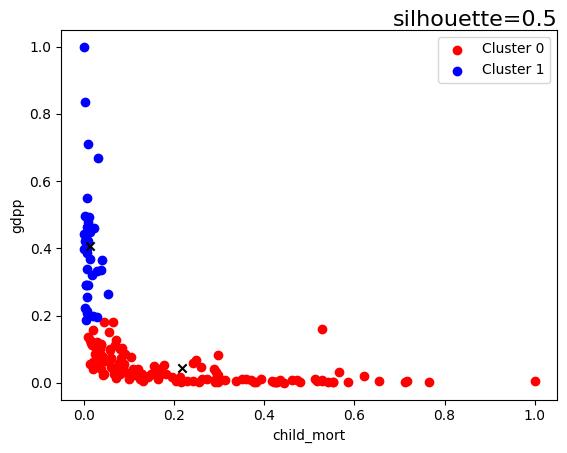

In [20]:
# Visualisation of clusters: child mortality vs gdpp
scatter_Kmeans(df_scaled[['child_mort', 'gdpp']].values, xlabel = 'child_mort', ylabel = 'gdpp')

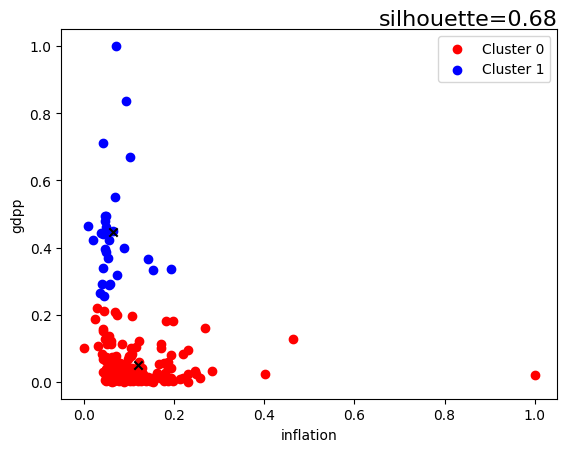

In [21]:
# Visualisation of clusters: inflation vs gdpp
scatter_Kmeans(df_scaled[['inflation', 'gdpp']].values, xlabel = 'inflation', ylabel = 'gdpp')

## Conclusions

Finally, I will label the groups of countries based on child mortality, GDPP and inflation, justifying the labels I assign to each group.

Analysing the first graph showing 'child_mort' vs 'gdpp', and looking at the centroids which represent average values of each cluster, cluster 0 has a moderate child mortality rate, and very low GDP per capita. On the other hand, cluster 1 has a very low child mortality rate, close to 0, and a much higer gdp per capita. Therefore, cluster 0 likely represents the least developed, and developing countries, while cluster 1 contains developed countries.

For the plot of 'inflation' vs 'gdpp', cluster 0 has a very low GDP per capita on average, and a slightly higher inflation than the other cluster - though not much different. Cluster 1 has a slightly lower inflation and a moderate to high gdp per capita. So, cluster 0 likely contains the least developed and developing countries, and cluster 1 represents developed countries.